**Feature Selection**


1. Import the data. These include the accelerometer predictors. We should consider doing a separate analysis without these variables, since relatively few participants have these data
2. Remove a couple of variables we won't be using, including:
    * id (the ID of the participant)
    * ID (another copy of ID - an artifact of a previous joining of data frames)
    * BIA-BIA_BMI (since we already have a BMI variable as part of the physical group)
    * PCIAT-PCIAT_01 through 20 (which are only used to compute PCIAT_Total)
3. To try to identify predictors that might be most strongly associated with the outcome variable (PCIAT_Total), we will examine correlations between each predictor (individually) and 
    * PCIAT-PCIAT_Total
    * log(PCIAT-PCIAT_Total)
    * (PCIAT-PCIAT_Total)^2
4. Examining NaN counts for all variables and, potentially, removing variables that:
    * Have very large NaN counts AND
    * Don't have face value as predictors AND
    * Have low correlations with the outcome variable
5. Examining correlations between all predictors and, potentially, removing variables that have extremely high (>0.98) correlation
6. Create sets of predictors grouped by predictors with NaNs in common (e.g., a set where a participant is likely to either have values for all of the predictors in the set or none of the predictors in the set). We will use these to try to identify whether *groups* of predictors are more important than others for predicting PCIAT scores
7. Several groups of variables include a "Season" predictor - e.g., the Season in which the FitnessGram variables were measured. Problematically, the PCIAT (i.e., outcome) variable has its own Season variable, and this doesn't necessarily match any of the other Season values. So, for example, a participant might have had their weight measured in the Spring and their PCIAT score measured in the Fall. We suspect that trying to include the Seasons as (categorical, or dummy variable encoded) predictors will be a bit problematic. However, we will explore interactions between Seasons and associated predictors to determine whether there appears to be a strong interaction between the Season and its associated variables in predicting PCIAT:
    1. For each predictor that is associated with a Season variable (e.g., within the Physical variables), make a scatterplot of the predictor vs. outcome and display regression lines by Season
    2. If there aren't any clear interactions, removing the Season variable from the list of predictors
    3. If there do appear to be interactions, creating dummy variables from the Season variable
8. Using RandomForest Regression on the entire set of predictors and examining the importance matrix to try to find a potential list of "key" predictors

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
# Load the original data set
train_cleaned = pd.read_csv('train_cleaned_outcome_imputed.csv')

In [139]:
train_cleaned.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
       'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIA

In [140]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove all PCIAT component variables from numeric features
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_0').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_1').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_2').columns))

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['sii', 'PCIAT-PCIAT_Total'])

In [141]:
# Compute absolute values of correlations between each predictor in numeric_features and PCIAT-PCIAT_Total
correlations = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['PCIAT-PCIAT_Total'])))

# Order correlations from largest to smallest
correlations = correlations.sort_values(ascending=False)

correlations.head(10)

Physical-Height                           0.417952
Basic_Demos-Age                           0.414704
PreInt_EduHx-computerinternet_hoursday    0.380958
Physical-Weight                           0.366635
BIA-BIA_FFM                               0.331195
BIA-BIA_BMR                               0.331195
BIA-BIA_LDM                               0.329734
BIA-BIA_LST                               0.328868
BIA-BIA_TBW                               0.325312
BIA-BIA_ECW                               0.323602
dtype: float64

Height, age, and weight are among the strong(er) predictors of the PCIAT_Total outcome, as well as responses to a survey about hours of internet use.

There appear to be a constellation of BIA variables that are predictors, but prior exploration suggests that these might be strongly correlated with height and weight (and maybe age), so they might be candidates for elimination.

It's possible that there are some non-linear associations. So we'll compute log and ^2 of the outcome variable and re-compute correlations

In [142]:
# Create a new variable that is log(PCIAT-PCIAT_Total)
train_cleaned['log_PCIAT-PCIAT_Total'] = np.log(train_cleaned['PCIAT-PCIAT_Total'])

# Replace -inf values in log_PCIAT-PCIAT_Total with -1
train_cleaned['log_PCIAT-PCIAT_Total'] = train_cleaned['log_PCIAT-PCIAT_Total'].replace(-np.inf, -1)

# Compute absolute values of correlations between each predictor in numeric_features and log_PCIAT-PCIAT_Total
correlations_log = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['log_PCIAT-PCIAT_Total'])))
correlations_log = correlations_log.sort_values(ascending=False)

correlations_log.head(10)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Physical-Height                           0.371523
Basic_Demos-Age                           0.363514
PreInt_EduHx-computerinternet_hoursday    0.314995
Physical-Weight                           0.307610
FGC-FGC_CU                                0.274599
BIA-BIA_LDM                               0.269430
BIA-BIA_FFM                               0.267541
BIA-BIA_BMR                               0.267541
BIA-BIA_LST                               0.265719
Physical-Waist_Circumference              0.265668
dtype: float64

The ordering of these variables is roughly unchanged, but the correlation values have decreased. So it doesn't seem to be the case that any of the predictors have a strong(er) correlation with log(PCIAT_Total)

In [143]:
# Create a new variable that is (PCIAT-PCIAT_Total)^2
train_cleaned['squared_PCIAT-PCIAT_Total'] = train_cleaned['PCIAT-PCIAT_Total']**2

# Compute absolute values of correlations between each predictor in numeric_features and squared_PCIAT-PCIAT_Total
correlations_squared = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['squared_PCIAT-PCIAT_Total'])))
correlations_squared = correlations_squared.sort_values(ascending=False)
correlations_squared.head(10)

Basic_Demos-Age                           0.381623
Physical-Height                           0.377574
PreInt_EduHx-computerinternet_hoursday    0.351885
Physical-Weight                           0.348412
BIA-BIA_BMR                               0.315812
BIA-BIA_FFM                               0.315812
BIA-BIA_LDM                               0.314103
BIA-BIA_LST                               0.312301
BIA-BIA_TBW                               0.310318
BIA-BIA_ECW                               0.306338
dtype: float64

Same results for the square relationship as with log. So we'll stick with examining linear relationships. We can remove the newly-created log/square predictors

In [144]:
# Remove the log_PCIAT-PCIAT_Total and squared_PCIAT-PCIAT_Total variables
train_cleaned = train_cleaned.drop(['log_PCIAT-PCIAT_Total', 'squared_PCIAT-PCIAT_Total'], axis=1)

In [145]:
# List the number of NaN values for each variable
train_cleaned.isnull().sum().sort_values(ascending=False).head(20)

Physical-Waist_Circumference        1818
Fitness_Endurance_Total_Time_Sec    1599
Fitness_Endurance-Max_Stage         1598
Positive_Anglez_Active_Days         1398
ENMO_Avg_Active_Days_MVPA110        1398
ENMO_Avg_Active_Days_MVPA192        1398
Fitness_Endurance-Season            1175
BIA-BIA_BMC                          764
BIA-BIA_FMI                          763
BIA-BIA_Fat                          763
PAQ_Zone                             753
PAQ_Season                           753
PAQ_Total                            753
BIA-BIA_FFMI                         745
BIA-BIA_BMI                          741
BIA-BIA_ICW                          739
BIA-BIA_LST                          739
BIA-BIA_TBW                          739
BIA-BIA_FFM                          739
BIA-BIA_ECW                          739
dtype: int64

There are some variables with a *lot* of missing information. But maybe the distribution (among participants) of number of NaN values is bimodal - perhaps there are a lot of people who are missing data for most of the variables.

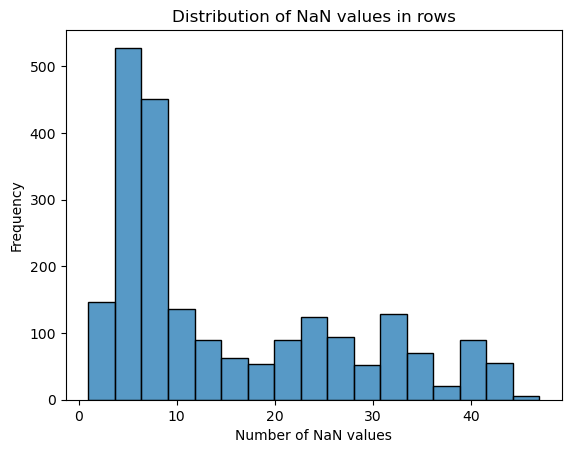

In [146]:
# Count the number of NaN values for each row and create a histogram of the distribution of these values
train_cleaned['NaN_count'] = train_cleaned.isnull().sum(axis=1)
sns.histplot(train_cleaned['NaN_count'])
plt.xlabel('Number of NaN values')
plt.ylabel('Frequency')
plt.title('Distribution of NaN values in rows')
plt.show()

The distribution looks multimodal. There are ~450 people who are missing data for nearly all of the variables, a group who are missing data for a few, and then no other groups that really stand out

These numbers are probably affected by the grouping into Physical, FitnessGram, and BIA—it seems likely that individuals would either have data for all of the predictors in a category or none of the predictors.

Doing regression requires values for all predictors. So we'll need to do one of the following: 
1. Focus on the ~300 participants who have data for (nearly) all of the variables, 
2. Focus only on the variables for which all participants have data
3. Some balance between these options -- eliminate a small number of high-NaN variables and then eliminate participants with NaN values in the remaining variables.

Alterntively, we can use imputation to fill in missing values.

Let's get a sense of how many independent features there really are. We'll figure out whether the Physical, FGC, and BIA variables tend to all be missing together. The goal is to create sets of variables that are all either present or not. We can then include these sets (or not) in various prediction methods.

The sets below were created by initially grouping variables by label (e.g., all variables that started with 'Physical'), then looking at the distribution of NaN counts. Bimodality in the distribution indicated that participants either had data for all of the variables in the group or had data for none of the variables in the group. If the distribution had more than two modes, the set was split into subsets that were bimodal 

In [147]:
# Create a list of all columns for each "group" of variables

physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
physical_features = physical_features.drop('Physical-Waist_Circumference')

physical_features_waist = ['Physical-Waist_Circumference']

FGC_GS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC-FGC_GS') & train_cleaned.columns.isin(numeric_features)]

FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
#FGC_features = FGC_features.append(pd.Index(['FitnessGram_Zone_Total']))
FGC_features = FGC_features.drop(FGC_GS_features)

BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]

PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]

SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]

fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]

Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]

ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']

PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


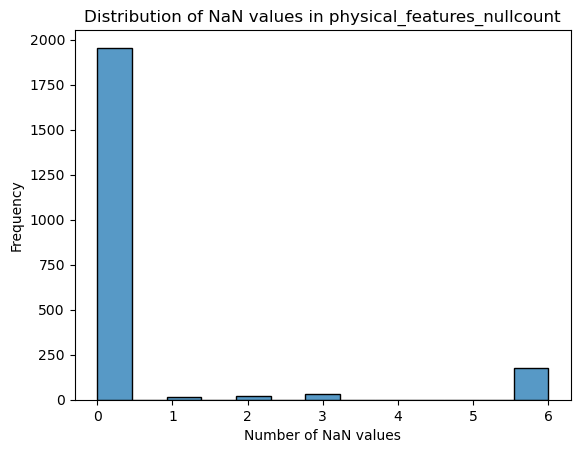

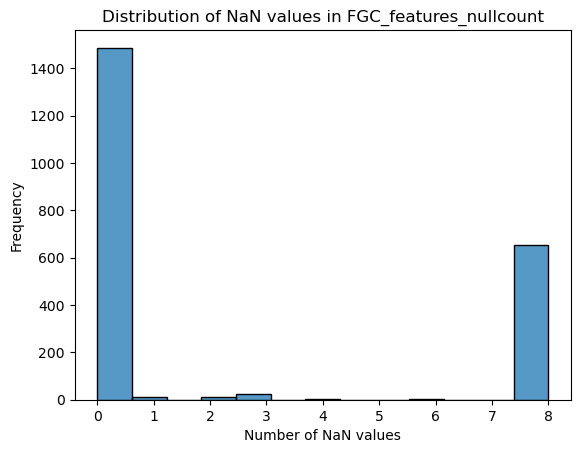

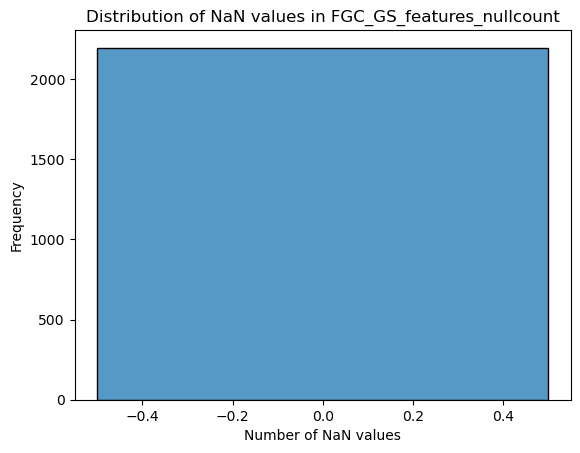

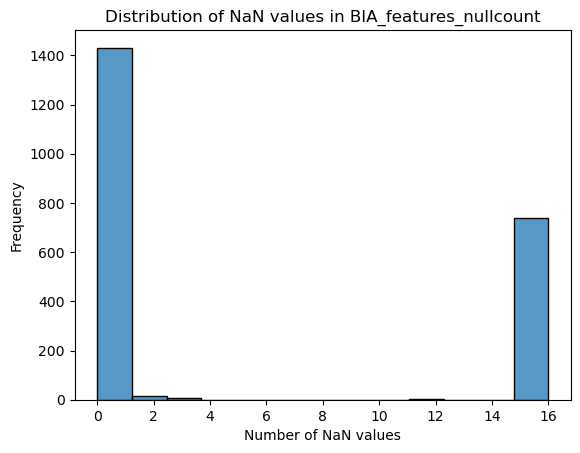

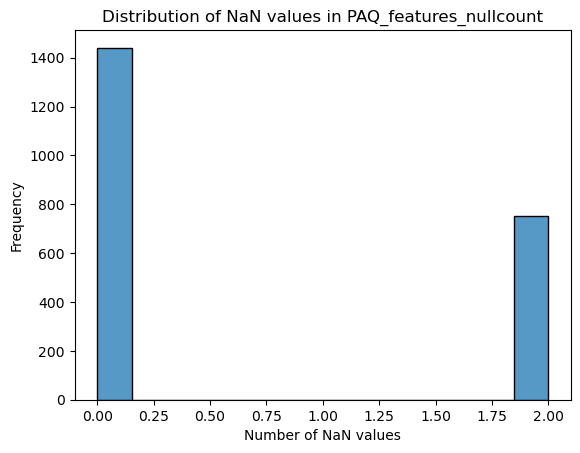

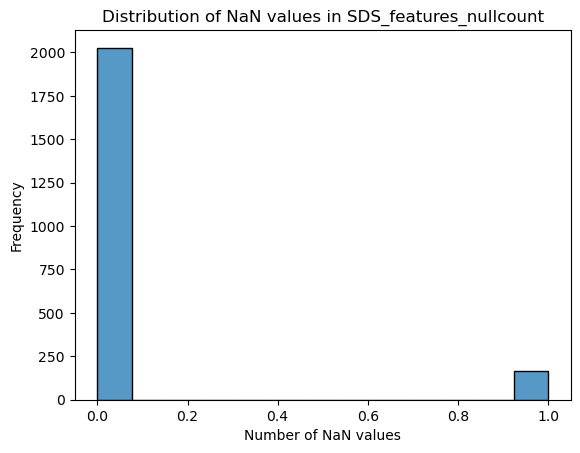

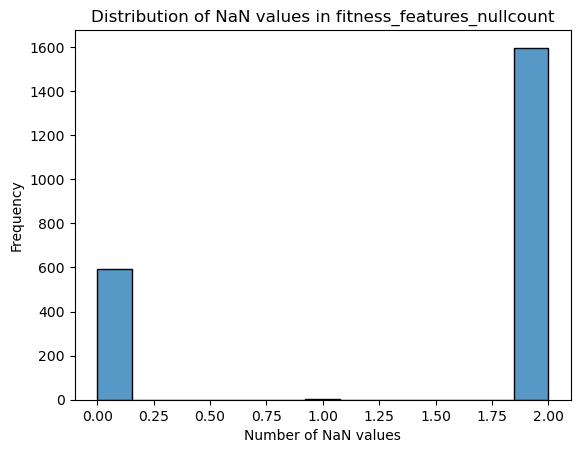

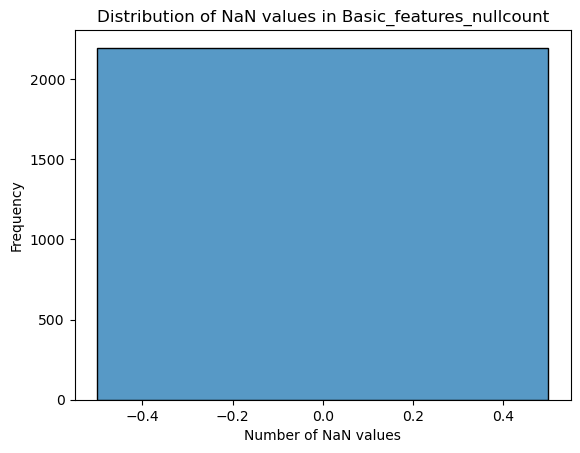

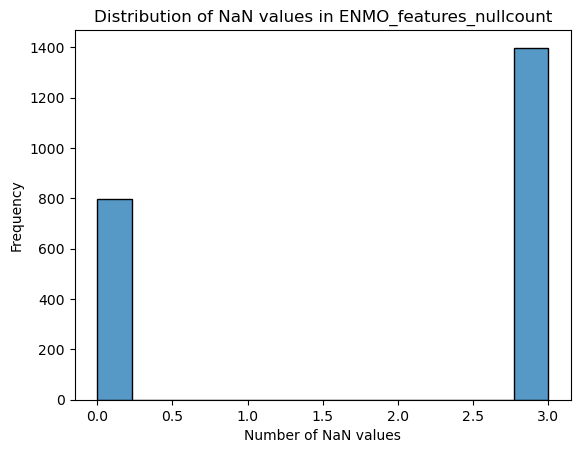

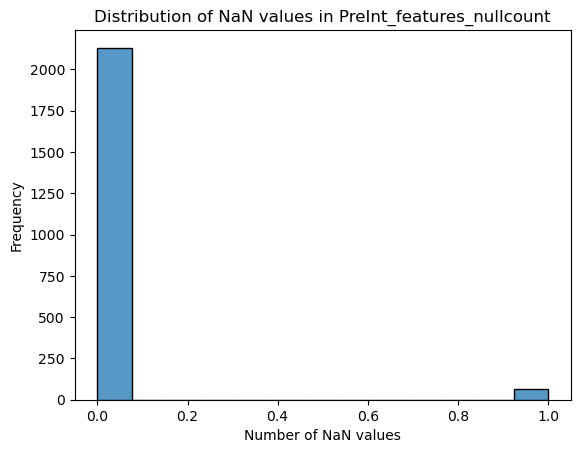

In [148]:
# Create a new variable that counts the number of NaN values among variables in the physical_features list
train_cleaned['physical_features_nullcount'] = train_cleaned[physical_features].isnull().sum(axis=1)
train_cleaned['FGC_features_nullcount'] = train_cleaned[FGC_features].isnull().sum(axis=1)
train_cleaned['FGC_GS_features_nullcount'] = train_cleaned[FGC_GS_features].isnull().sum(axis=1)
train_cleaned['BIA_features_nullcount'] = train_cleaned[BIA_features].isnull().sum(axis=1)
train_cleaned['PAQ_features_nullcount'] = train_cleaned[PAQ_features].isnull().sum(axis=1)
train_cleaned['SDS_features_nullcount'] = train_cleaned[SDS_features].isnull().sum(axis=1)
train_cleaned['fitness_features_nullcount'] = train_cleaned[fitness_features].isnull().sum(axis=1)
train_cleaned['Basic_features_nullcount'] = train_cleaned[Basic_features].isnull().sum(axis=1)
train_cleaned['ENMO_features_nullcount'] = train_cleaned[ENMO_features].isnull().sum(axis=1)
train_cleaned['PreInt_features_nullcount'] = train_cleaned[PreInt_features].isnull().sum(axis=1)

# Make a set of histograms for each variable that ends in '_nullcount'
for feature in train_cleaned.columns:
    if feature.endswith('_nullcount'):
        sns.histplot(train_cleaned[feature])
        plt.xlabel('Number of NaN values')
        plt.ylabel('Frequency')
        plt.title('Distribution of NaN values in ' + feature)
        plt.show()

In [149]:
# Remove variables from train_cleaned that end with _nullcount
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.endswith('_nullcount')]

# Remove the NaN_Count variable from train_cleaned
train_cleaned = train_cleaned.drop('NaN_count', axis=1)

Next, we'll examine correlations between predictors. The goal is to, potentially, eliminate some predictors that are highly correlated.

In [150]:
# Compute absolute value of correlation between variables in numeric_features
correlation_matrix = train_cleaned[numeric_features].corr().abs()

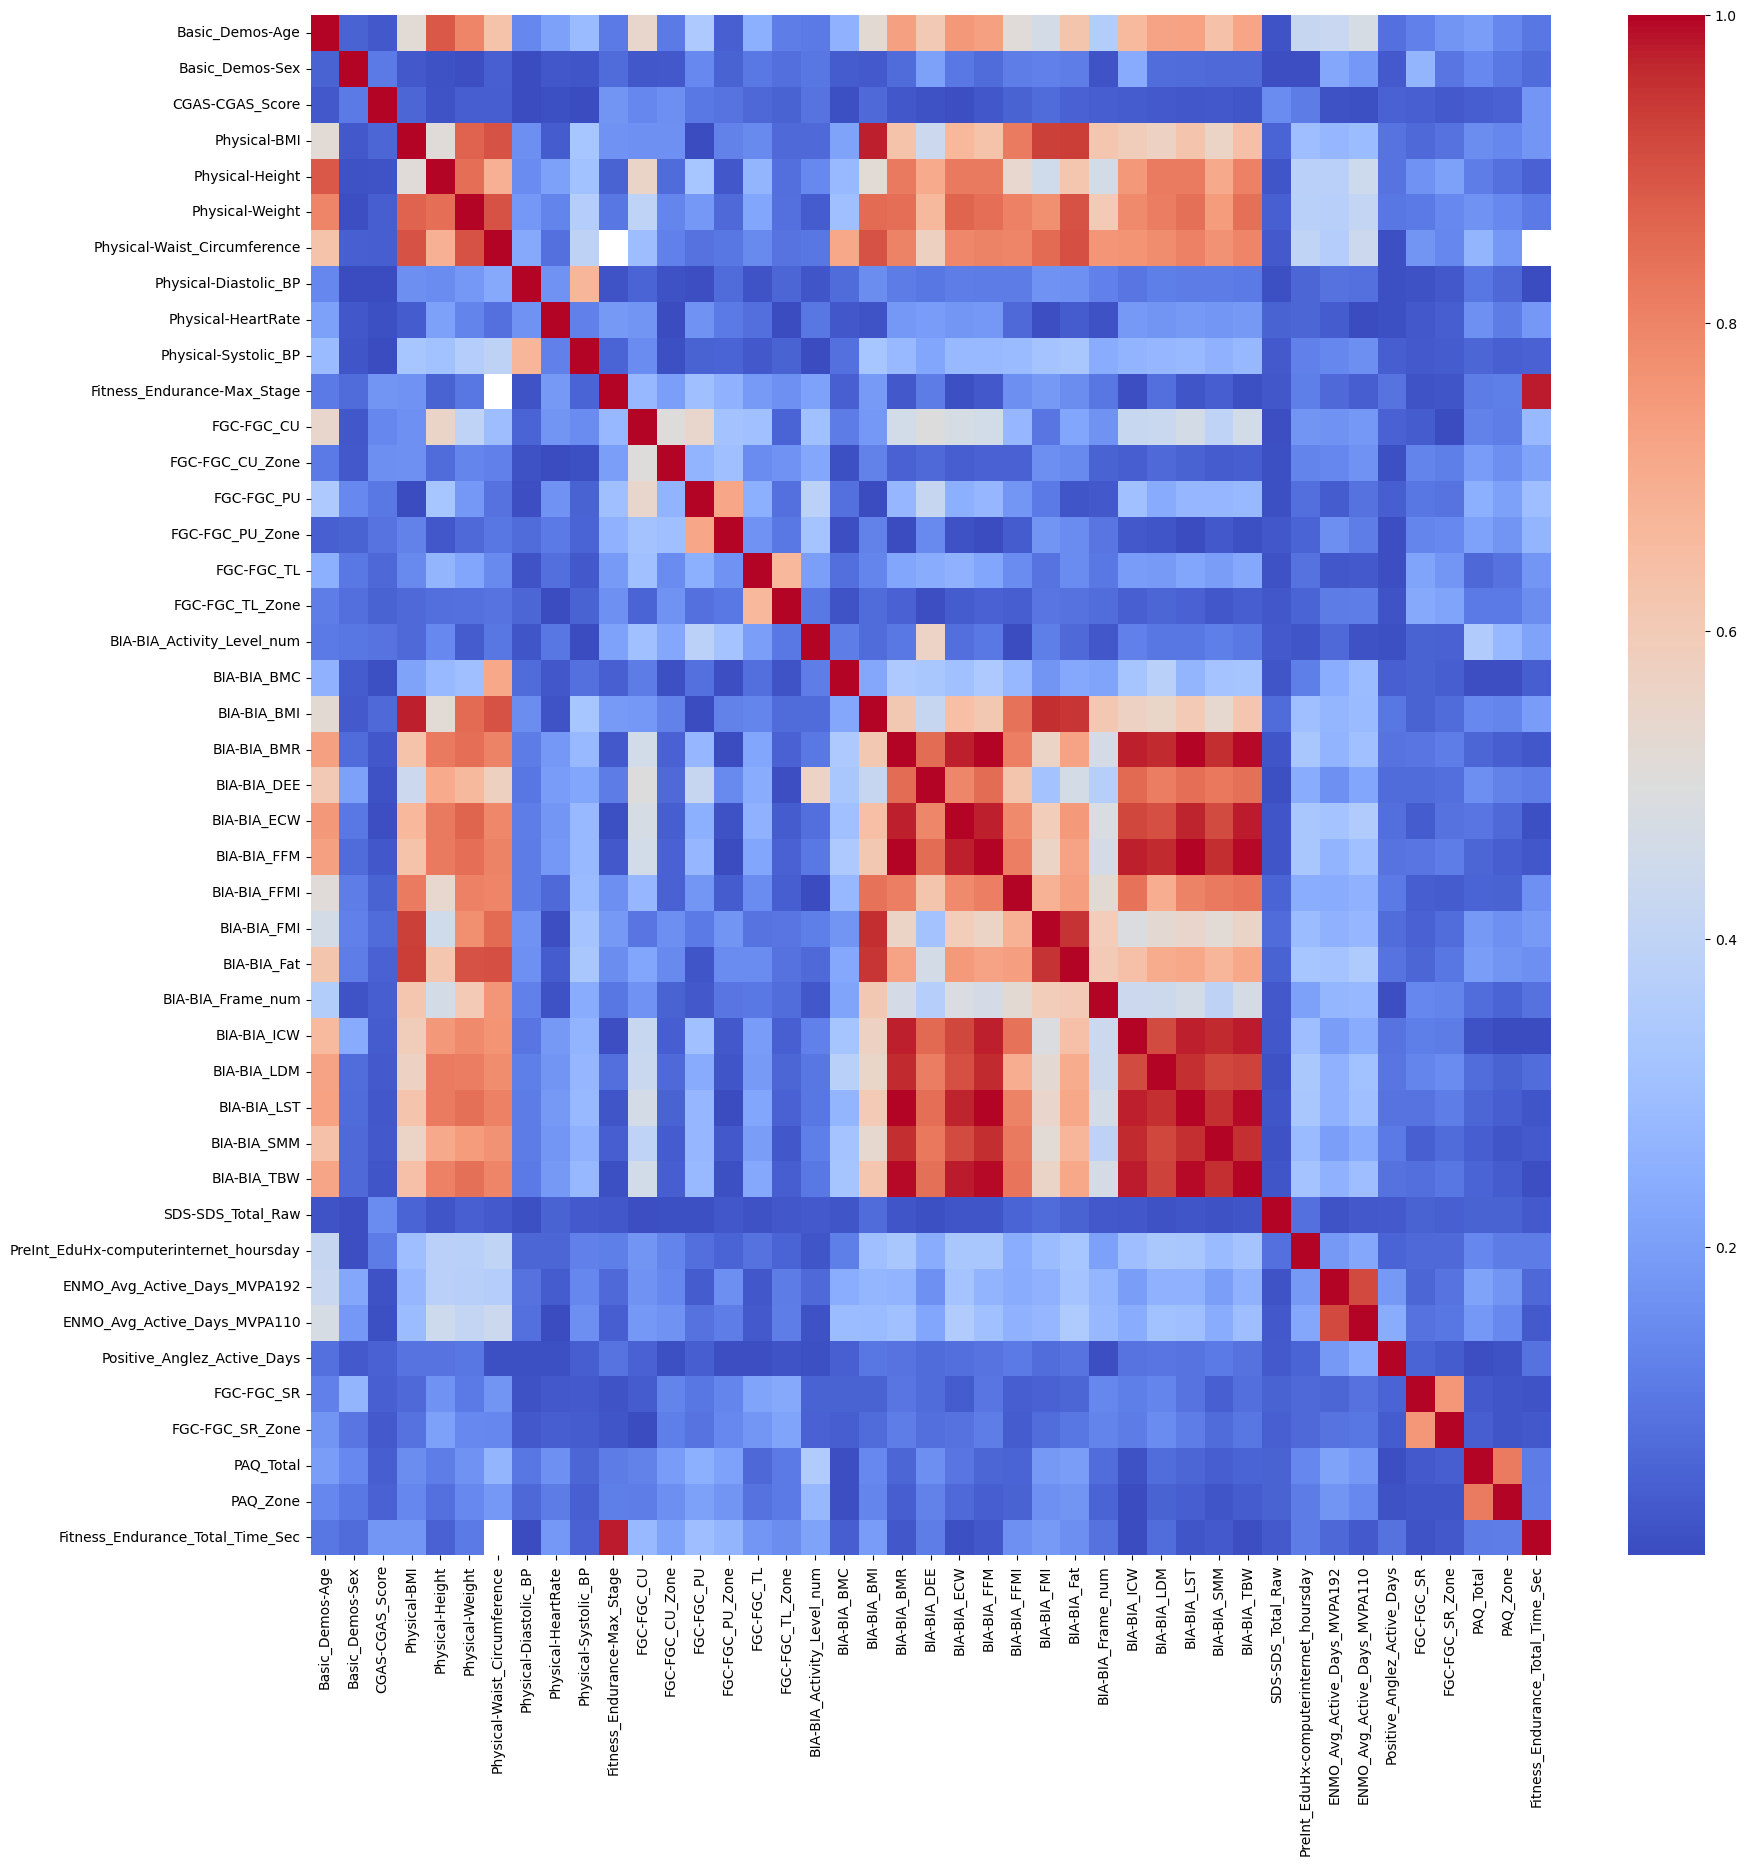

In [151]:
# Create a 20x20 heatmap of correlation_matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [152]:
# List the values in correlation_matrix from largest to smallest, only including values at least 0.85 and less than 1
correlation_matrix = correlation_matrix.unstack()
correlation_matrix = correlation_matrix.sort_values(ascending=False)
correlation_matrix = correlation_matrix[correlation_matrix != 1]
correlation_matrix = correlation_matrix[correlation_matrix >= 0.9]

# Show all values in correlation_matrix without truncating output
pd.set_option('display.max_rows', None)
correlation_matrix

BIA-BIA_BMR                       BIA-BIA_FFM                         1.000000
BIA-BIA_FFM                       BIA-BIA_BMR                         1.000000
BIA-BIA_LST                       BIA-BIA_BMR                         0.996551
BIA-BIA_BMR                       BIA-BIA_LST                         0.996551
BIA-BIA_FFM                       BIA-BIA_LST                         0.996551
BIA-BIA_LST                       BIA-BIA_FFM                         0.996551
BIA-BIA_TBW                       BIA-BIA_BMR                         0.994868
BIA-BIA_BMR                       BIA-BIA_TBW                         0.994868
BIA-BIA_FFM                       BIA-BIA_TBW                         0.994868
BIA-BIA_TBW                       BIA-BIA_FFM                         0.994868
BIA-BIA_LST                       BIA-BIA_TBW                         0.992867
BIA-BIA_TBW                       BIA-BIA_LST                         0.992867
                                  BIA-BIA_ICW       

Some of these predictos are highly correlated. 

**BIA Variable Removal**

Some of the BIA variables appear to either be redundant or computed from each other:
* BIA-BIA_BMI is measuring BMI. It has correlation 0.965105 with Physical_BMI. I can't find any information about how it is any different. It seems likely that BMI varies from day to day and measurement to measurement, so the difference is likely due to measurement error. Going to remove BIA-BIA_BMI

The other BIA variables are:
* BIA-BIA_BMC	Bone Mineral Content
* BIA-BIA_BMR	Basal Metabolic Rate
* BIA-BIA_DEE	Daily Energy Expenditure
* BIA-BIA_LDM	Lean Dry Mass
* BIA-BIA_LST	Lean Soft Tissue
* BIA-BIA_SMM	Skeletal Muscle Mass
* BIA-BIA_FFM	Fat Free Mass
* BIA-BIA_Fat	Body Fat Percentage
* BIA-BIA_Frame_num	Body Frame
* BIA-BIA_TBW	Total Body Water
* BIA-BIA_ECW	Extracellular Water
* BIA-BIA_ICW	Intracellular Water
* BIA-BIA_FMI	Fat Mass Index: Calcuated as FM divided by height squared
* BIA-BIA_FFMI	Fat Free Mass Index: Calcuated as FFM divided by height squared

There exist large correlations between many pairs of these predictors. Below is a list of all pairs with at least 0.99 correlation:
* FFM	BMR	0.9999999999991445
* BMR	TBW	0.9996843922178612
* FFM	TBW	0.9996843882486972
* ECW	BMR	0.99949744961038
* ECW	FFM	0.9994974489820077
* TBW	ECW	0.9994121539401678
* TBW	ICW	0.9989842717508111
* FFM	LDM	0.9989337841842884
* BMR	LDM	0.9989337768885788
* SMM	ICW	0.9984531398777805
* ICW	BMR	0.9981423016493606
* FFM	ICW	0.998142293296351
* ECW	LDM	0.9980088142821305
* TBW	SMM	0.9976684856970098
* TBW	LDM	0.9974587197051186
* ICW	LST	0.9969014072300802
* SMM	BMR	0.996864975676666
* FFM	SMM	0.9968649649869374
* ECW	ICW	0.996852207975357
* LST	SMM	0.9967543066184706
* SMM	ECW	0.9957140182568774
* TBW	LST	0.995487594282981
* BMC	LDM	0.9950199542105168
* LDM	ICW	0.9949518859314233
* ICW	DEE	0.9948088046663506
* DEE	TBW	0.9944107160263206
* DEE	BMR	0.9941186367579632
* DEE	FFM	0.9941186344807962
* LDM	SMM	0.9937473329914341
* LST	BMR	0.9936088620550899
* LST	FFM	0.99360884373626
* DEE	SMM	0.9933843458863473
* LST	ECW	0.9930574064543182
* ECW	DEE	0.992754802616644
* DEE	LDM	0.9919453675327521
* FFM	BMC	0.9914085178617896
* BMR	BMC	0.9914084966327703
* LST	DEE	0.9912776109118937
* BMC	ECW	0.9909706551293764

If we keep the BIA-BIA_FFM variable, then we could eliminate:
* BMR
* TBW
* ECW
* ICW
* LDM
* SMM
* DEE
* LST
* BMC

**Other Variables**

* SDS Variables
    * SDS_Total_Raw and SDS_Total_T appear essentially the same, so we could just drop Total_T
* Fitness_Endurance
    * Max_Stage and Total_Time_Sec appear basically the same. And I'm assuming that Max_Stage is a function of Total_Time_Sec. So we could just drop Max_Stage
* FGC
    * Grip strength Non-dominant and Dominant are reasonably correlated, but not quite the same. Maybe keep them for now because they're measuring sort-of fundamentally different things?
    * Sit & reach left vs right - seems like these should really be the same. Even though they're less correlated than others, I'm going to drop SRL

**Exploring Seasons**

As discussed above, it is possible that there is an interaction between season and the predictive power of individual variables. We'll look at these potential interactions via graphs below.

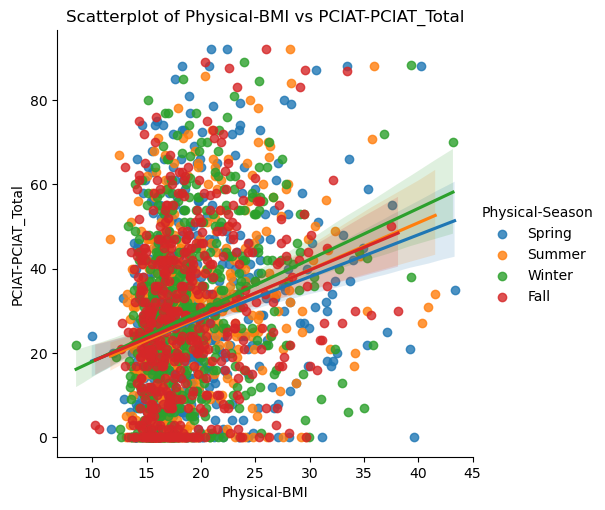

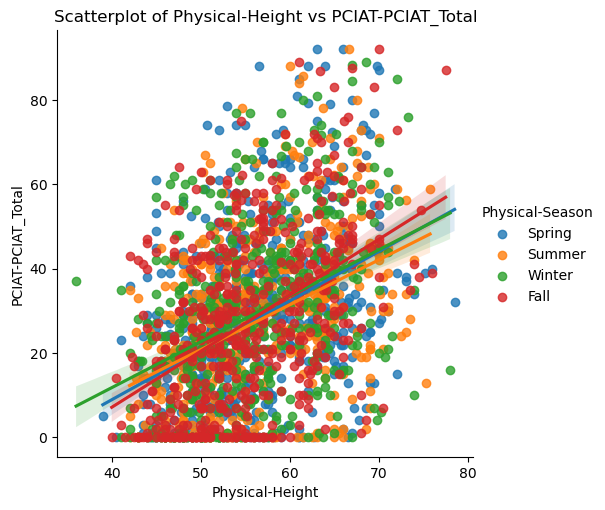

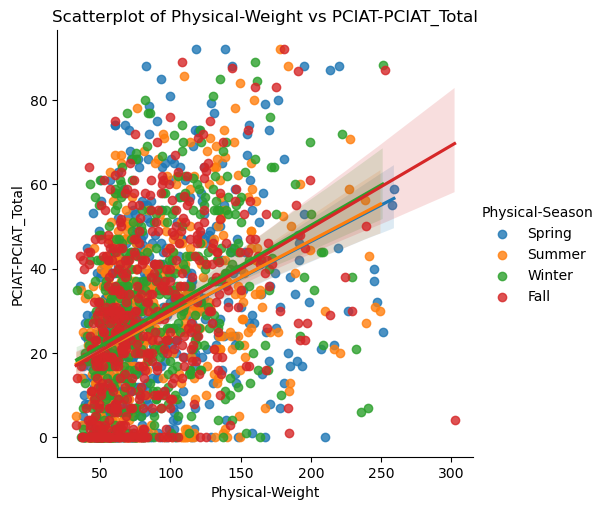

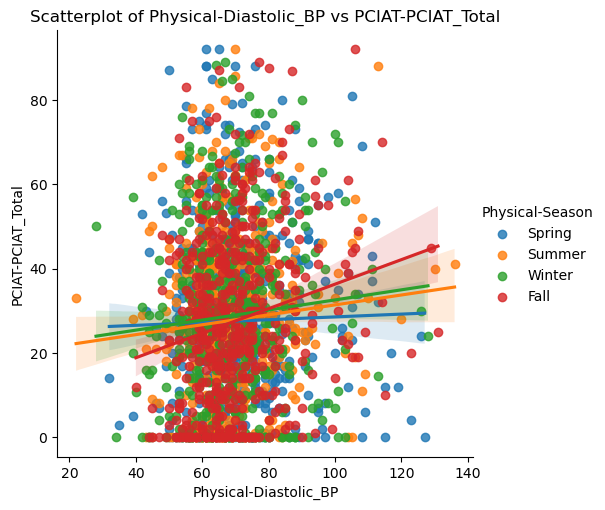

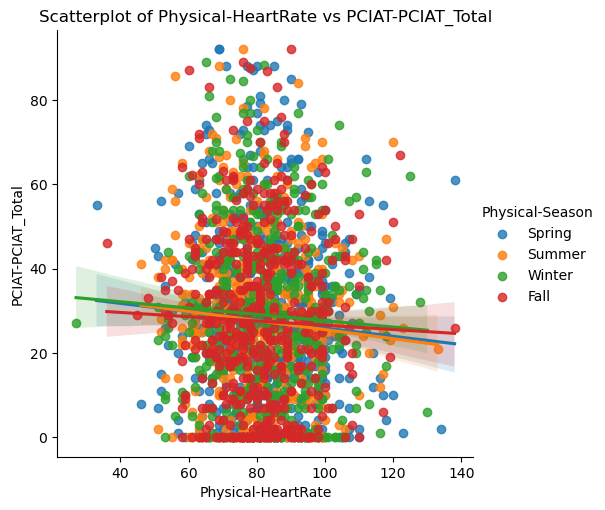

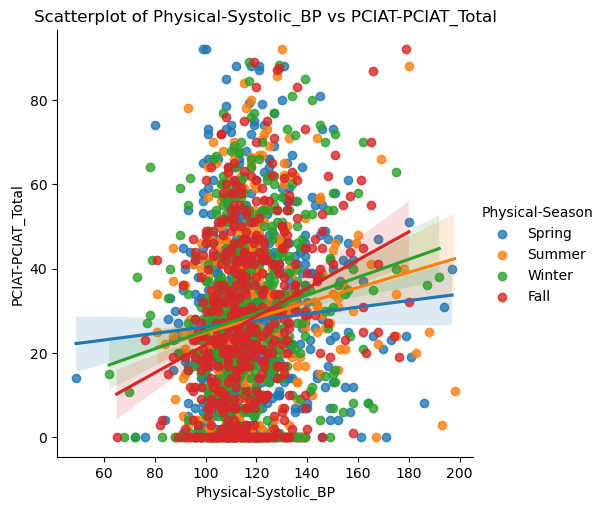

In [153]:
# For each variable in physical_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by Physical-Season. Add a line of best fit for each value of Physical-Season
for feature in physical_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='Physical-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

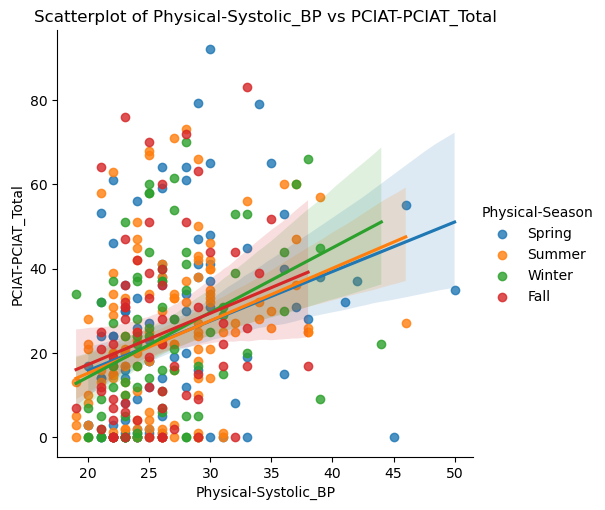

In [154]:
# For each variable in physical_features_waist, make a scatterplot vs PCIAT-PCIAT_Total with points colored by Physical-Season. Add a line of best fit for each value of Physical-Season

sns.lmplot(data=train_cleaned, x='Physical-Waist_Circumference', y='PCIAT-PCIAT_Total', hue='Physical-Season')
plt.xlabel(feature)
plt.ylabel('PCIAT-PCIAT_Total')
plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
plt.show()

**Interpretation**

There do appear to be some small effects of season on the extent to which the physical variables predict PCIAT scores. However, there don't appear to be particularly strong patterns in the data.

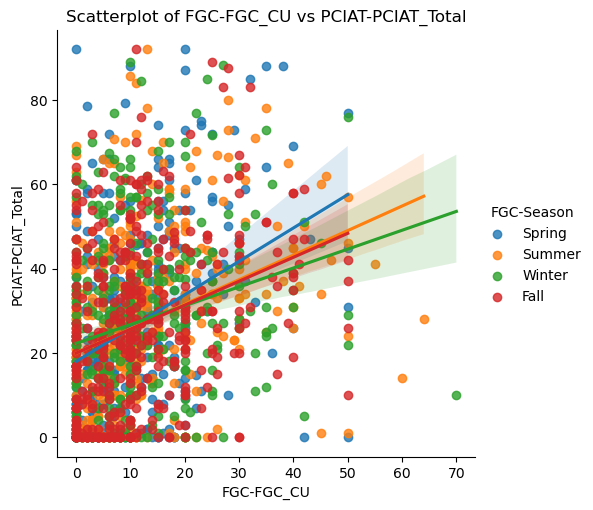

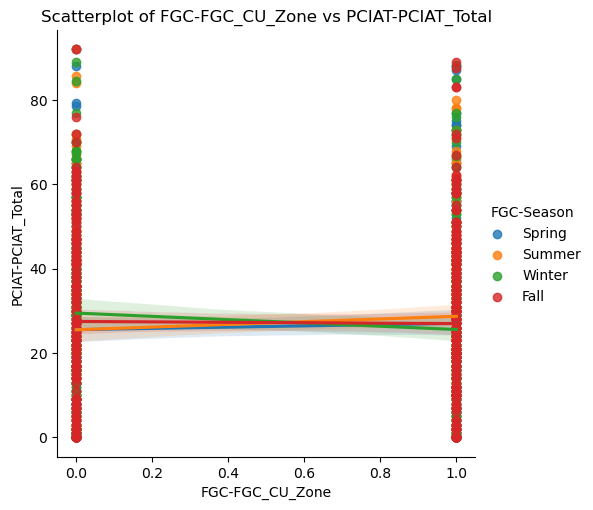

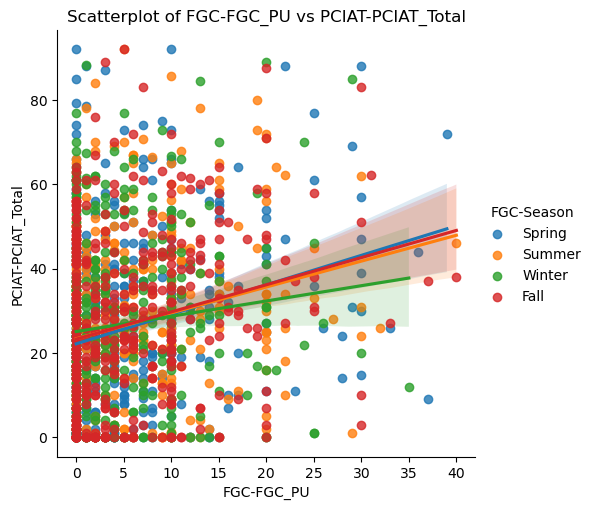

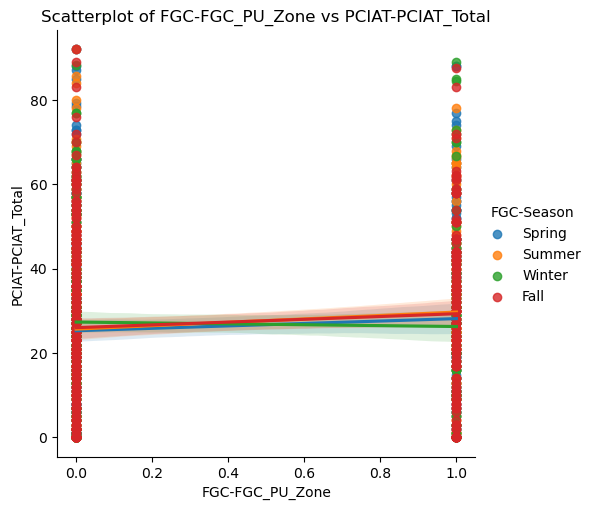

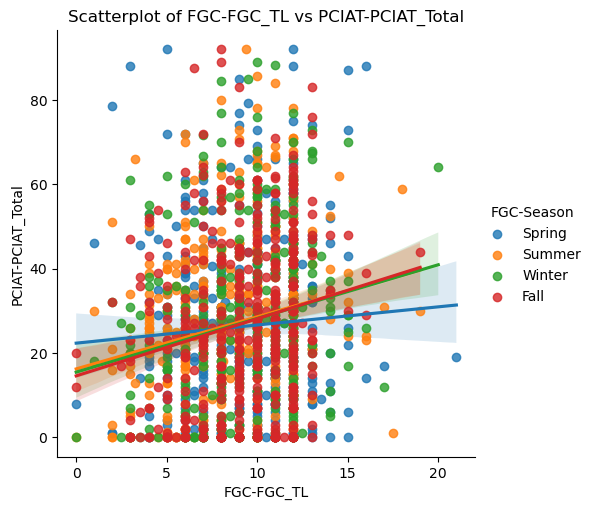

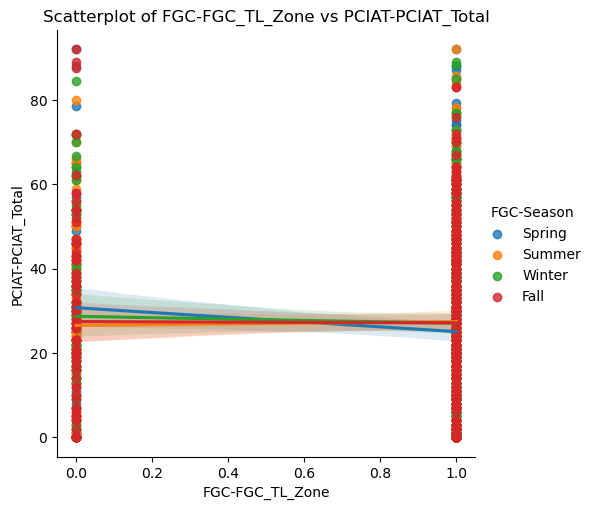

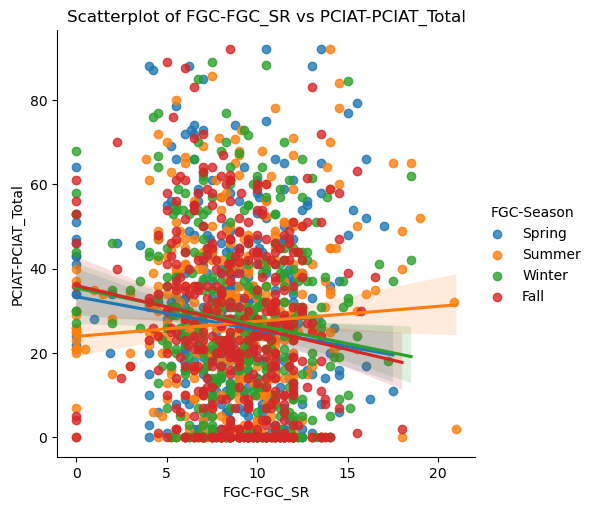

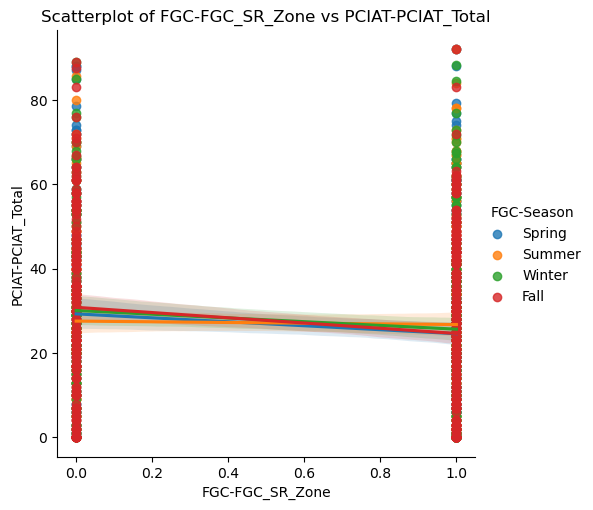

In [155]:
# For each variable in FGC_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by FGC-Season. Add a line of best fit for each value of FGC-Season
for feature in FGC_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='FGC-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There appears to be a slight effect of season on the sit & reach test prediction of PCIAT

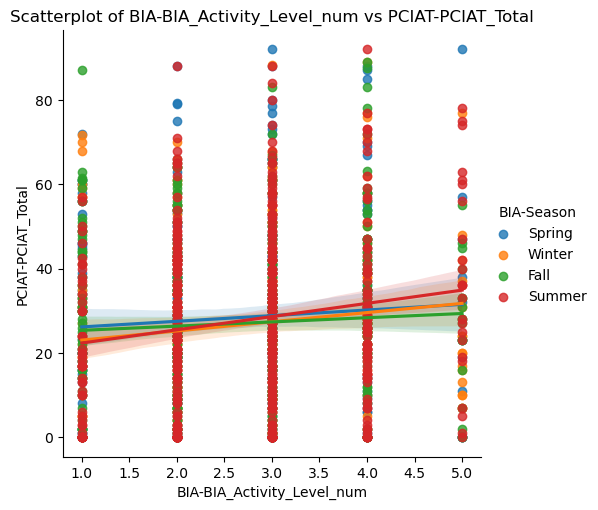

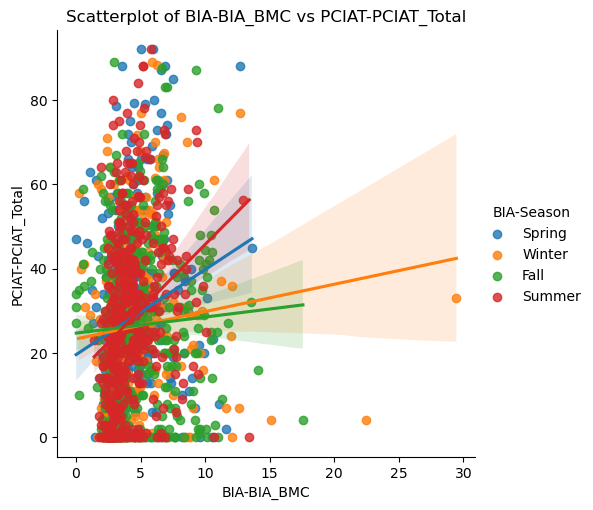

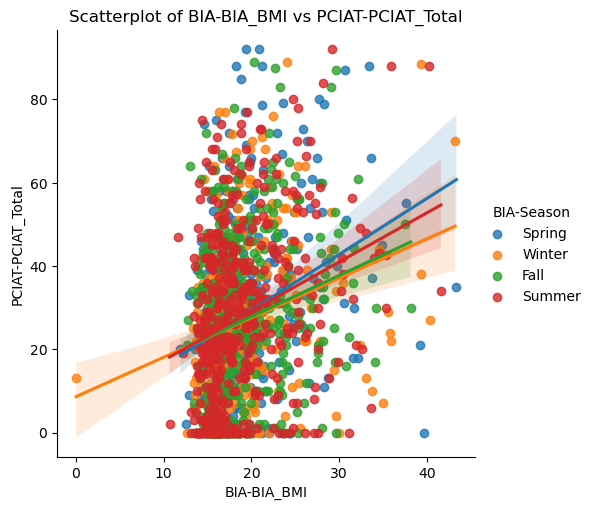

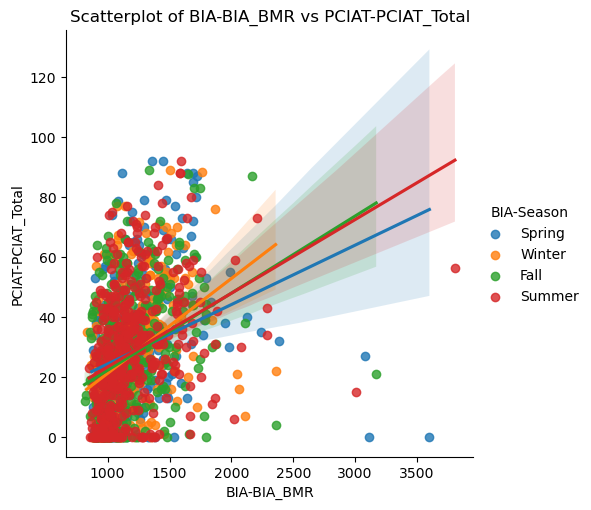

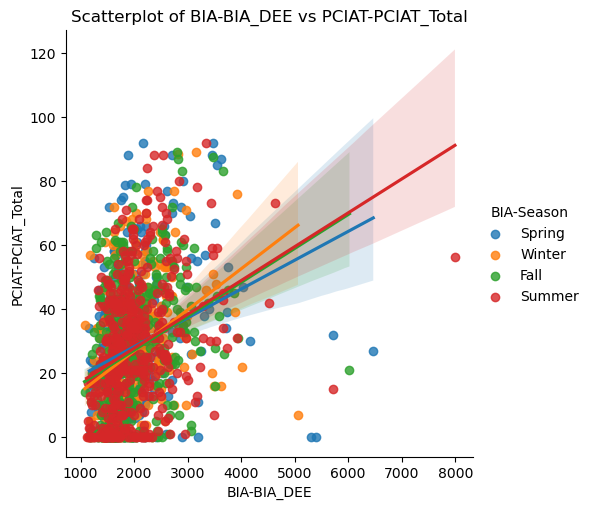

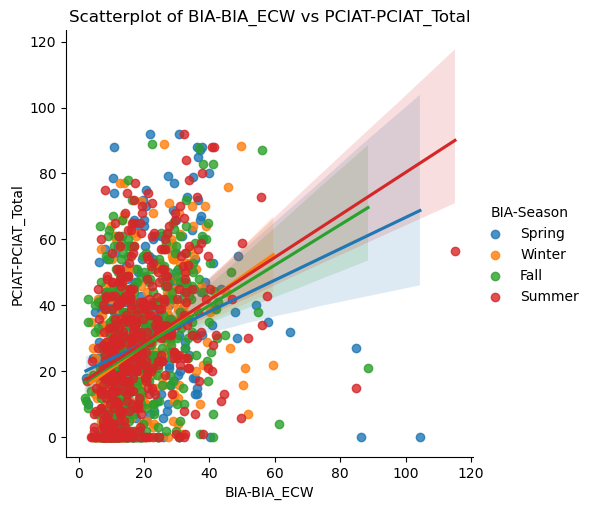

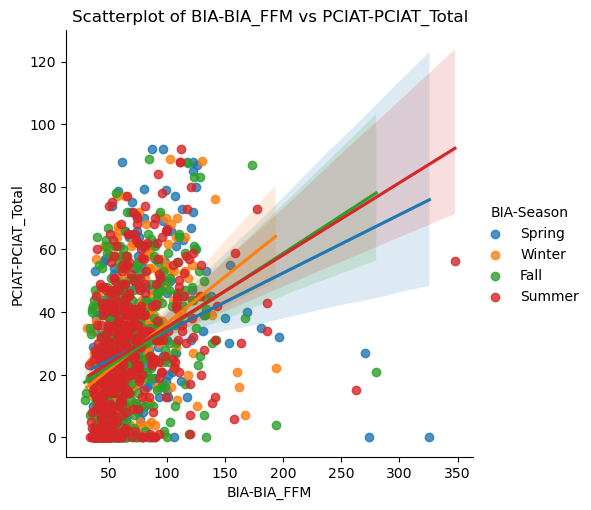

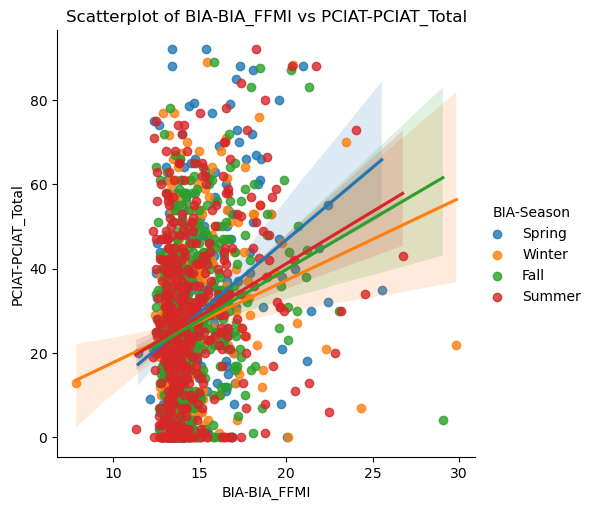

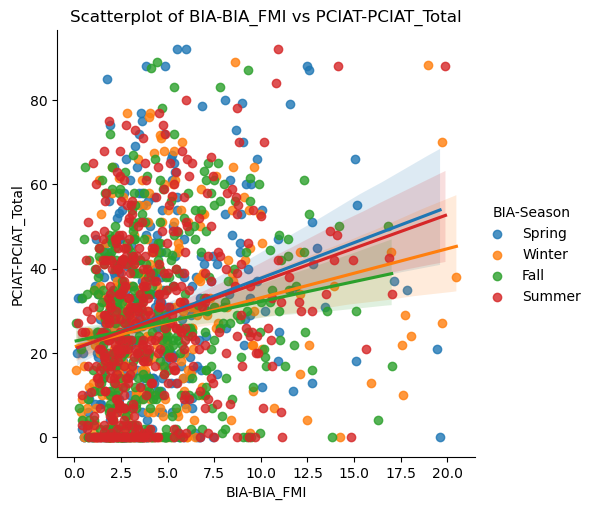

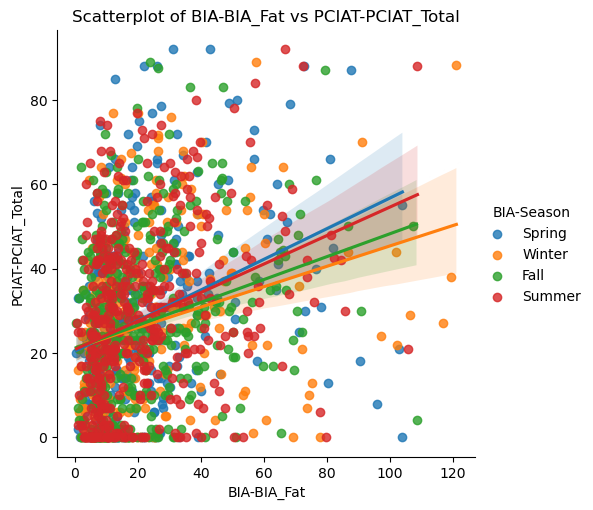

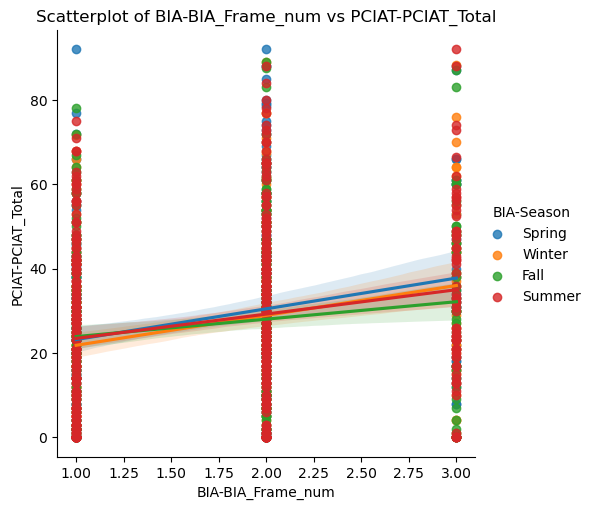

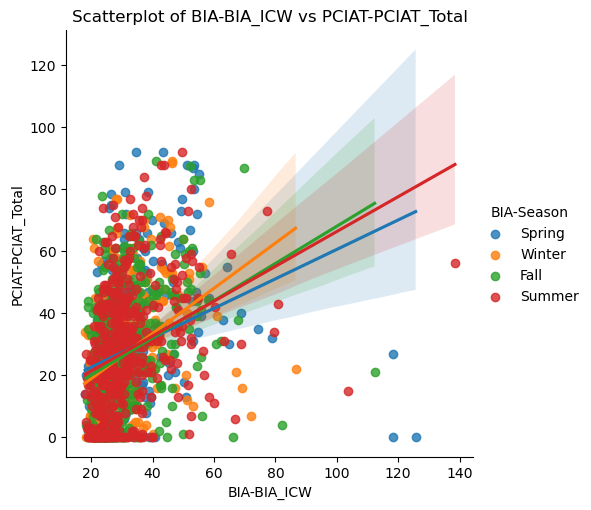

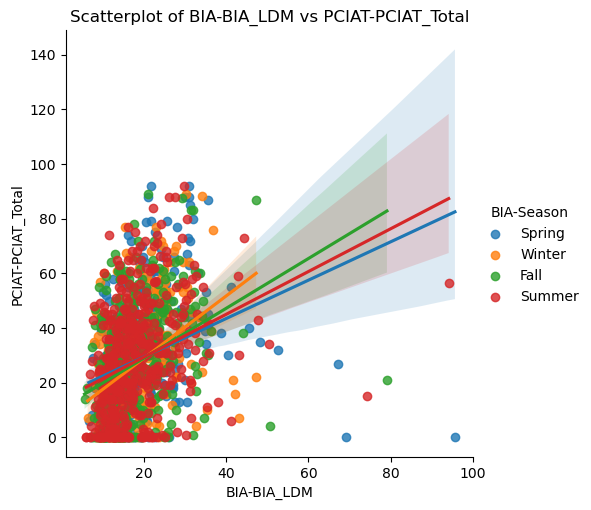

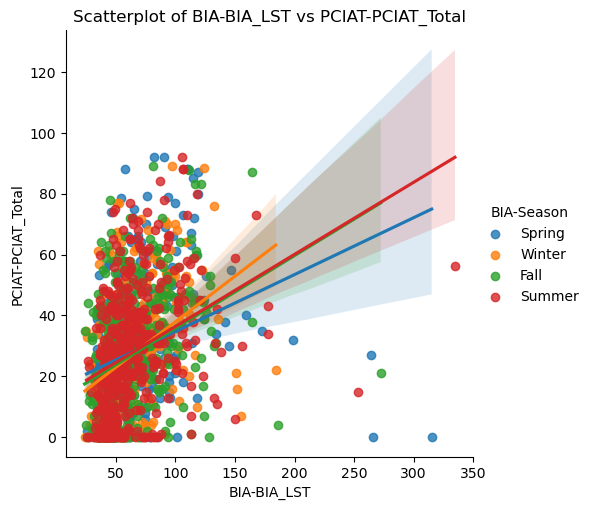

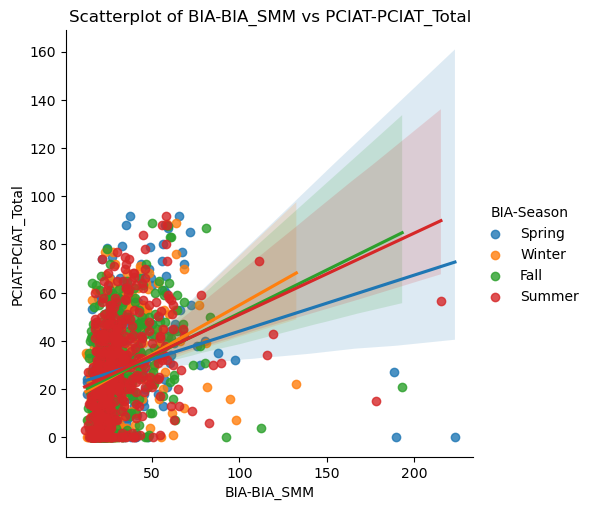

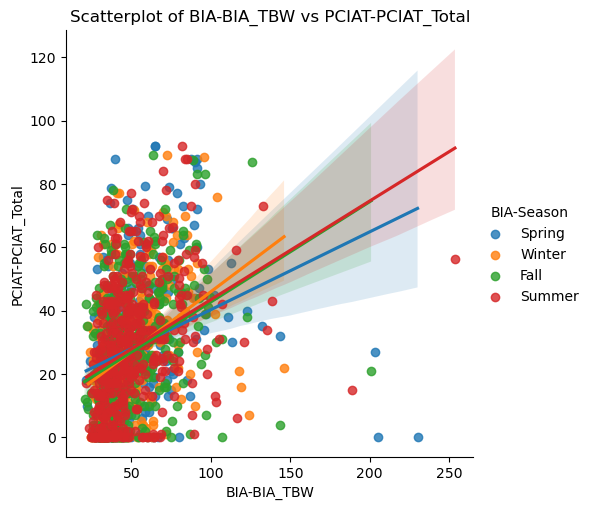

In [156]:
# For each variable in BIA_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by . Add a line of best fit for each value of BIA-Season
for feature in BIA_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='BIA-Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There doesn't appear to be any interaction between the BIA variables and PCIAT scores

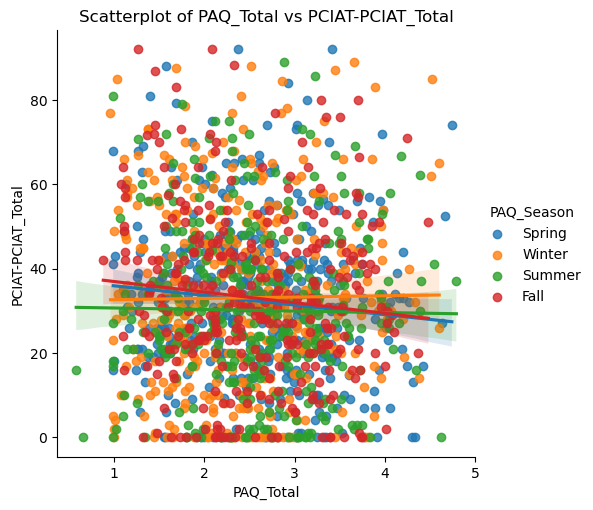

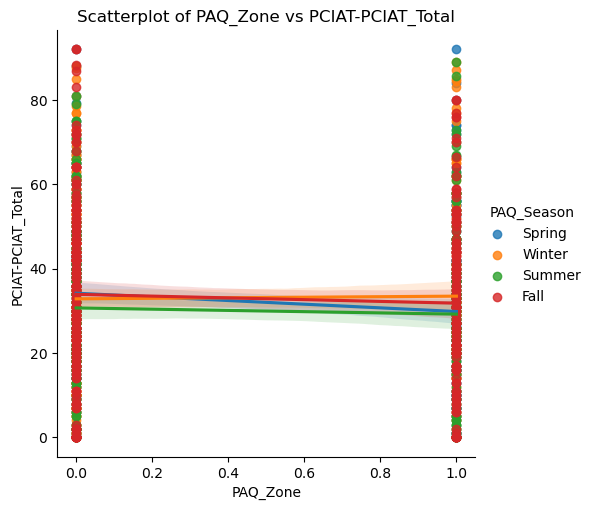

In [157]:
# For each variable in PAQ_features, make a scatterplot vs PCIAT-PCIAT_Total with points colored by PAQ-Season. Add a line of best fit for each value of PAQ_Season
for feature in PAQ_features:
    sns.lmplot(data=train_cleaned, x=feature, y='PCIAT-PCIAT_Total', hue='PAQ_Season')
    plt.xlabel(feature)
    plt.ylabel('PCIAT-PCIAT_Total')
    plt.title('Scatterplot of ' + feature + ' vs PCIAT-PCIAT_Total')
    plt.show()

**Interpretation**

There doesn't appear to be any interaction between season and the predictive power of PAQ scores.

**Overall Discussion of Season Interactions**

There don't appear to be many (if any) interactions between the Season variable and other predictor variables. We note that PCIAT also has a season variable, which would require further exploration.

It also seems possible that there might be some sort of "cohorting" effect - that is, for groups of participants who all got the same collection of measures in the same seasonal order. But identifying these effects is going to be beyond the scope of our exploration, so we will end up dropping the Season variables.

**Removing Features**

In this section, we'll remove all the features (identified above) that we think aren't necessary for constructing models

In [158]:
# Remove some variables we won't need

# Remove the variables 'id', 'BIA-BIA_BMI'
train_cleaned = train_cleaned.drop(['id', 'BIA-BIA_BMI'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, and FGC-FGC_TL_Zone
train_cleaned = train_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_TL_Zone'], axis=1)

# Remove the following variables from train: BIA-BIA_BMR, BIA-BIA_TBW, BIA-BIA_ECW, BIA-BIA_LDM, BIA-BIA_ICW, BIA-BIA_SMM, BIA-BIA_DEE, BIA-BIA_LST, and BIA-BIA_BMC
train_cleaned=train_cleaned.drop(columns=['BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_ECW', 'BIA-BIA_LDM', 'BIA-BIA_ICW', 'BIA-BIA_SMM', 'BIA-BIA_DEE', 'BIA-BIA_LST', 'BIA-BIA_BMC'])

# Remove the Fitness_Endurance-Max_Stage variable (based on previous exploration)
train_cleaned = train_cleaned.drop(['Fitness_Endurance-Max_Stage'], axis=1)

# Remove all variables with Season in their name
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.contains('Season')]

**Expore the Feature-Selected Predictors**

In [159]:
# Export train_cleaned to a csv named train_cleaned_feature_selected.csv
train_cleaned.to_csv('train_cleaned_outcome_imputed_feature_selected.csv', index=False)

**Predictive Power for Groups of Predictors**

In this section, we'll explore whether groups of variables (as opposed to single variables) might be better predictors of PCIAT.

We'll start creating linear models using all combinations of the predictor sets

There are 11 predictor sets, so there will be a total of 2^11=2048 combinations of sets

For each combination, we'll do a 5-fold cross-validation and compute the mean MSE

Then we'll look at the combinations of predictor sets with the lowest mean MSE

The computations seem to be winnowing down the size of the data set more than anticipated, so I'll be inserting some additional code to see where this is happening

In [160]:
# Load all the things we'll need
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# First, split the entire data set into training and testing to use as a final check on the models we build
# Setting a value for random_state to diagnose buggy code
Training_Set, Testing_Set = train_test_split(train_cleaned,
                                                       shuffle = True,
                                                       random_state = 216,
                                                       test_size = .2)

In [161]:
# Count the number of NaN values in PCIAT-PCIAT_Total in train_cleaned, Training_Set, and Testing_Set:
print('Number of total entries in the train_cleaned:', len(train_cleaned))
print('Number of non-NaN entries in the train_cleaned:', len(train_cleaned) - train_cleaned['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Training_Set:', len(Training_Set))
print('Number of non-NaN entries in PCIAT_Total for Training_Set:', len(Training_Set) - Training_Set['PCIAT-PCIAT_Total'].isna().sum())

print('Number of total entries in the Testing_Set:', len(Testing_Set))
print('Number of non-NaN entries in PCIAT_Total for Testing_Set:', len(Testing_Set) - Testing_Set['PCIAT-PCIAT_Total'].isna().sum())

Number of total entries in the train_cleaned: 2194
Number of non-NaN entries in the train_cleaned: 2194
Number of total entries in the Training_Set: 1755
Number of non-NaN entries in PCIAT_Total for Training_Set: 1755
Number of total entries in the Testing_Set: 439
Number of non-NaN entries in PCIAT_Total for Testing_Set: 439


In [162]:
# Next we'll set up the power set of the groups and create a dataframe to hold the members of the power set and the mean MSE for that collection

# Create a list of all columns for each "group" of variables
physical_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Physical') & train_cleaned.columns.isin(numeric_features)]
physical_features = physical_features.drop('Physical-Waist_Circumference')
physical_features_waist = ['Physical-Waist_Circumference']
FGC_features = train_cleaned.columns[train_cleaned.columns.str.startswith('FGC') & train_cleaned.columns.isin(numeric_features)]
BIA_features = train_cleaned.columns[train_cleaned.columns.str.startswith('BIA') & train_cleaned.columns.isin(numeric_features)]
PAQ_features = train_cleaned.columns[train_cleaned.columns.str.startswith('PAQ') & train_cleaned.columns.isin(numeric_features)]
SDS_features = train_cleaned.columns[train_cleaned.columns.str.startswith('SDS') & train_cleaned.columns.isin(numeric_features)]
fitness_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Fitness_') & train_cleaned.columns.isin(numeric_features)]
Basic_features = train_cleaned.columns[train_cleaned.columns.str.startswith('Basic') & train_cleaned.columns.isin(numeric_features)]
ENMO_features = ['ENMO_Avg_Active_Days_MVPA192', 'ENMO_Avg_Active_Days_MVPA110', 'Positive_Anglez_Active_Days']
PreInt_features = ['PreInt_EduHx-computerinternet_hoursday']


# Create a list of all groups of features
groups = [physical_features, physical_features_waist, FGC_features, BIA_features, PAQ_features, SDS_features, fitness_features, Basic_features, ENMO_features, PreInt_features]

# This function returns the power set of a set minus the empty set.  
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

# Create the power set of the groups of features
features_groups_powerset = powerset(groups)

## This is the baseline model
features_groups_powerset.append([['baseline']])

# Each element of the powerset is a list of lists. To extract the features from each list of lists, we'll need to be able to 'flatten' the list of lists into a list
def flatten(inlist):
    flat_list = []
    for element in inlist:
        flat_list.extend(element)
    return flat_list

In [163]:
# Set up a 5-fold split to use with the linear models
num_splits = 5

#Create a numpy array with num_splits columns and len(features_groups_powerset) rows to hold the MSE values
cv_mses = np.zeros((len(features_groups_powerset), num_splits))

#Create a numpy array with len(features_groups_powerset) rows to hold the number of valid observations in each split
cv_sizes = np.zeros((len(features_groups_powerset), num_splits))

#Make a KFold object; setting random_state for now to help diagnose any issues with the code
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)

## loop through all splits
i = 0
for train_index, test_index in kfold.split(Training_Set):
    #print('Iteration:',i)
    ## get train and holdout sets
    problematic_train_train = Training_Set.iloc[train_index]
    problematic_train_holdout = Training_Set.iloc[test_index]

    #loop through all models
    j = 0
    for featureset in features_groups_powerset:
        #print('Featureset:',featureset)
        featureset_flattened = flatten(featureset)
        #print('Featureset Flattened:',featureset_flattened)

        if featureset_flattened == ['baseline']:
            #print('Featureset was baseline')
        
            # Drop NaNs from problematic_train_train for the 'PCIAT-PCIAT_Total' variable
            problematic_train_train_copy = problematic_train_train.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train_copy))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout_copyp))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                problematic_train_train_mean = problematic_train_train_copy['PCIAT-PCIAT_Total'].mean()
                #print('Prediction is:',problematic_train_train_mean)
                predict = problematic_train_train_mean * np.ones(len(problematic_train_holdout_copy))
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else: cv_mses[j,i]=np.nan
        else:
            # Drop NaNs from problematic_train_train where the variables are either in featureset_flattened or are equal to 'PCIAT-PCIAT_Total'
            problematic_train_train_copy = problematic_train_train.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_train')
            #print('Remaining observations in train set is', len(problematic_train_train))
            problematic_train_holdout_copy = problematic_train_holdout.dropna(subset=featureset_flattened + ['PCIAT-PCIAT_Total'])
            #print('NaNs dropped from train_holdout')
            #print('Remaining observations in holdout set is', len(problematic_train_holdout))

            cv_sizes[j,i] = len(problematic_train_train_copy)+len(problematic_train_holdout_copy)

            if len(problematic_train_train_copy)>0 and len(problematic_train_holdout_copy)>0:
                ## make clone
                reg = LinearRegression(copy_X = True)
            
                ## fit clone
                reg.fit(problematic_train_train_copy[featureset_flattened], problematic_train_train_copy['PCIAT-PCIAT_Total'])
                #print('LinReg has been fit')
                predict = reg.predict(problematic_train_holdout_copy[featureset_flattened])
                #print('LinReg has been predicted')

                # Set the value of feature_combinations where the value of 'predictor_list' is equal to featureset and the column is equal to i
                cv_mses[j,i] = mean_squared_error(problematic_train_holdout_copy['PCIAT-PCIAT_Total'], predict)
                #print('Value has been set')
            else:
                cv_mses[j,i] = np.nan
        j=j+1
    i=i+1

In [164]:
# Compute the mean of each row in cv_mses
cv_mses_means = np.mean(cv_mses, axis=1)

# Compute the mean of each row in cv_sizes
cv_sizes_means = np.mean(cv_sizes, axis=1)

# Create a new dataframe where the first column is features_groups_powerset and the second column is cv_mses_means
MSE_Group_Comparison = pd.DataFrame({'featureset': features_groups_powerset, 'Mean_MSE': cv_mses_means, 'Non_NAN_Observations':cv_sizes_means})


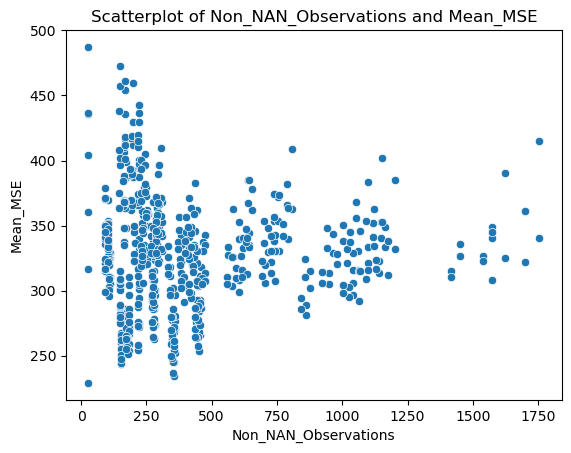

In [165]:
# Create a scatterplot of Non_NAN_Observations and Mean_MSE in MSE_Group_Comparison_filtered. Add a trendline
sns.scatterplot(data=MSE_Group_Comparison[MSE_Group_Comparison['Mean_MSE'] < 500], x='Non_NAN_Observations', y='Mean_MSE')
plt.xlabel('Non_NAN_Observations')
plt.ylabel('Mean_MSE')
plt.title('Scatterplot of Non_NAN_Observations and Mean_MSE')
plt.show()

**Interpretation**

This graph shows that there is some tradeoff between predictive power (i.e., low MSE) and availability of data (i.e., large numbers of non-NAN observations)

In the sections below, we'll try to identify a couple of collections of variables that have various balances between these tradeoffs

In [166]:
# Compute a metric to try to balance large observations and small MSE
MSE_Group_Comparison['Non_NAN_Observations_divided_by_Mean_MSE'] = MSE_Group_Comparison['Non_NAN_Observations'] / MSE_Group_Comparison['Mean_MSE']

In [167]:
MSE_Group_Comparison.sort_values(by='Non_NAN_Observations_divided_by_Mean_MSE', ascending=False).head(10)

featureset    Mean_MSE  \
639  [[Basic_Demos-Age, Basic_Demos-Sex], [PreInt_E...  322.317250   
127               [[Basic_Demos-Age, Basic_Demos-Sex]]  340.710641   
671  [[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...  308.242365   
159  [[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...  325.087318   
640  [[Physical-BMI, Physical-Height, Physical-Weig...  322.452866   
511         [[PreInt_EduHx-computerinternet_hoursday]]  360.980217   
512  [[Physical-BMI, Physical-Height, Physical-Weig...  326.942746   
128  [[Physical-BMI, Physical-Height, Physical-Weig...  340.322171   
672  [[Physical-BMI, Physical-Height, Physical-Weig...  310.140773   
543  [[SDS-SDS_Total_Raw], [PreInt_EduHx-computerin...  344.900336   

     Non_NAN_Observations  Non_NAN_Observations_divided_by_Mean_MSE  
639                1701.0                                  5.277409  
127                1755.0                                  5.150998  
671                1573.0                                  5.103127  
159                1623.0                                  4.992505  
640                1538.0                                  4.769689  
511                1701.0                                  4.712170  
512                1538.0                                  4.704188  
128                1573.0                                  4.622091  
672                1418.0                                  4.572117  
543                1573.0                                  4.560738

In [168]:
# Identify rows in MSE_Group_Comparison with Mean_MSE less than 296 and Non_NAN_Observations between 750 and 1100
MSE_Group_Comparison[(MSE_Group_Comparison['Mean_MSE'] < 296) & (MSE_Group_Comparison['Non_NAN_Observations'] > 750) & (MSE_Group_Comparison['Non_NAN_Observations'] < 1100)]

featureset    Mean_MSE  \
555  [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  288.942376   
556  [[Physical-BMI, Physical-Height, Physical-Weig...  293.985345   
675  [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  291.825216   
679  [[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...  294.704555   
683  [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  280.893217   
684  [[Physical-BMI, Physical-Height, Physical-Weig...  285.895033   

     Non_NAN_Observations  Non_NAN_Observations_divided_by_Mean_MSE  
555                 862.0                                  2.983294  
556                 843.0                                  2.867490  
675                1066.0                                  3.652871  
679                1025.0                                  3.478060  
683                 862.0                                  3.068782  
684                 843.0                                  2.948635

In [169]:
# Identify rows in MSE_Group_Comparison where the featureset string includes 'ENMO'
ENMO_Comparison = MSE_Group_Comparison[MSE_Group_Comparison['featureset'].astype(str).str.contains('ENMO')]

In [170]:
# Sort ENMO_Comparison by Non_NAN_Observations_divided_by_Mean_MSE
ENMO_Comparison.sort_values(by='Non_NAN_Observations_divided_by_Mean_MSE', ascending=False).head(10)

featureset    Mean_MSE  \
895  [[Basic_Demos-Age, Basic_Demos-Sex], [ENMO_Avg...  313.108929   
896  [[Physical-BMI, Physical-Height, Physical-Weig...  310.625507   
768  [[Physical-BMI, Physical-Height, Physical-Weig...  315.520595   
383  [[Basic_Demos-Age, Basic_Demos-Sex], [ENMO_Avg...  335.293073   
927  [[SDS-SDS_Total_Raw], [Basic_Demos-Age, Basic_...  303.769519   
767  [[ENMO_Avg_Active_Days_MVPA192, ENMO_Avg_Activ...  340.059829   
384  [[Physical-BMI, Physical-Height, Physical-Weig...  332.651409   
928  [[Physical-BMI, Physical-Height, Physical-Weig...  304.939388   
256  [[Physical-BMI, Physical-Height, Physical-Weig...  340.384000   
800  [[Physical-BMI, Physical-Height, Physical-Weig...  310.186447   

     Non_NAN_Observations  Non_NAN_Observations_divided_by_Mean_MSE  
895                 637.0                                  2.034436  
896                 617.0                                  1.986315  
768                 617.0                                  1.955498  
383                 642.0                                  1.914743  
927                 577.0                                  1.899466  
767                 637.0                                  1.873200  
384                 621.0                                  1.866819  
928                 558.0                                  1.829872  
256                 621.0                                  1.824410  
800                 558.0                                  1.798918

In [171]:
# Sort MSE_Group_Comparison by Mean_MSE
MSE_Group_Comparison.sort_values(by='Mean_MSE').head(10)

featureset    Mean_MSE  \
773   [[Physical-Waist_Circumference], [FGC-FGC_CU, ...  229.133472   
743   [[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...  234.060774   
747   [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  236.748366   
967   [[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...  243.788479   
999   [[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...  244.063829   
615   [[BIA-BIA_Activity_Level_num, BIA-BIA_FFM, BIA...  245.115399   
619   [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  245.155305   
1003  [[FGC-FGC_CU, FGC-FGC_PU, FGC-FGC_TL, FGC-FGC_...  247.310210   
744   [[Physical-BMI, Physical-Height, Physical-Weig...  248.107157   
748   [[Physical-BMI, Physical-Height, Physical-Weig...  249.728503   

      Non_NAN_Observations  Non_NAN_Observations_divided_by_Mean_MSE  
773                   28.0                                  0.122200  
743                  355.0                                  1.516700  
747                  352.0                                  1.486811  
967                  154.0                                  0.631695  
999                  152.0                                  0.622788  
615                  355.0                                  1.448297  
619                  352.0                                  1.435825  
1003                 152.0                                  0.614613  
744                  347.0                                  1.398589  
748                  344.0                                  1.377496

Two candidates for our sets are where
* Non_NAN_Observations = 1566 and Mean_MSE=296.874168 (index 1343)
* Non_NAN_Observations = 1043 and Mean_MSE = 280.300321 (index 1351)

These sets of predictors are, respectively:
* SDS_features, Basic_Features, and PreInt_features
* FGC_features, SDS_features, Basic_Features, and PreInt_features

If we wanted to include ENMO features, we could include:
* Non_NAN_Observations = 626 and Mean_MSE = 302.116609 (index 1791)
* Non_NAN_Observations = 570 and Mean_MSE = 296.152815 (index 1855)

These sets of predictors are, respectively:
* ENMO_Features, Basic_Features, and PreInt_features
* ENMO_Features, SDS_features, Basic_Features, and PreInt_features

If we wanted to minimize MSE, we could use:
* Non_NAN_Observations = 219 and Mean_MSE = 238.084131 (index 1527)
* Non_NAN_Observations = 346 and Mean_MSE = 243.001698 (index 1495)

These sets of predictors are, respectively:
* FGC_Feagures, BIA_Features, PAQ_Features, SDS_Features, Fitness_Features, Basic_Features, and PreInt_features
* FGC_Features, BIA_Features, SDDS_Features, Fitness_Features, Basic_Features, and PreInt_features

**Interpretation**

These sets provide us with some candidates for "key features" we could use to test linear models as predictors of PCIAT scores.

**Random Forest for Feature Selection**

In this section, we will run a RandomForest regressor on the set of predictors to identify variables with relatively large importance scores. We'll then use these to create a list of "key features" that we can use when comparing models.

In [172]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

In [173]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from CustomImputers import *


pipe_mice = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_mice.fit(train_cleaned[predictors],train_cleaned['PCIAT-PCIAT_Total'])

train_pred_mice = pipe_mice.predict(train_cleaned[predictors])

#Get feature importance from the rf inside pipe
score_mice_df = pd.DataFrame({'feature':train_cleaned[predictors].columns,
                            'importance_score': pipe_mice.named_steps['rf'].feature_importances_})

score_mice_df.sort_values('importance_score',ascending=False)


feature  importance_score
0                          Basic_Demos-Age          0.134744
20  PreInt_EduHx-computerinternet_hoursday          0.128712
4                          Physical-Height          0.113239
14                             BIA-BIA_FFM          0.088525
19                       SDS-SDS_Total_Raw          0.075877
5                          Physical-Weight          0.073809
22            ENMO_Avg_Active_Days_MVPA110          0.070334
10                              FGC-FGC_CU          0.051529
6             Physical-Waist_Circumference          0.026613
17                             BIA-BIA_Fat          0.024879
11                              FGC-FGC_PU          0.023109
15                            BIA-BIA_FFMI          0.021086
26                               PAQ_Total          0.016362
3                             Physical-BMI          0.015255
24                              FGC-FGC_SR          0.014908
12                              FGC-FGC_TL          0.014868
2                          CGAS-CGAS_Score          0.013269
16                             BIA-BIA_FMI          0.011467
21            ENMO_Avg_Active_Days_MVPA192          0.010680
23             Positive_Anglez_Active_Days          0.010038
9                     Physical-Systolic_BP          0.009960
7                    Physical-Diastolic_BP          0.009691
28        Fitness_Endurance_Total_Time_Sec          0.009687
8                       Physical-HeartRate          0.009650
13              BIA-BIA_Activity_Level_num          0.007630
1                          Basic_Demos-Sex          0.006515
18                       BIA-BIA_Frame_num          0.006428
25                         FGC-FGC_SR_Zone          0.001135
27                                PAQ_Zone          0.000000

In [174]:
keyfeatures = ['Basic_Demos-Age',
 'Physical-Height',
 'PreInt_EduHx-computerinternet_hoursday',
 'BIA-BIA_FFM',
 'SDS-SDS_Total_Raw',
 'Physical-Weight',
 'ENMO_Avg_Active_Days_MVPA110',
 'FGC-FGC_CU']